In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import itertools
import json
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind

from numpy.polynomial import Polynomial
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mtick
from modules import *

In [3]:
mpl.rcParams['font.size'] = 18
mpl.rcParams['figure.figsize'] = (10, 6)
PATH = "../summary/img"

## Brassinoslide Concentration Function

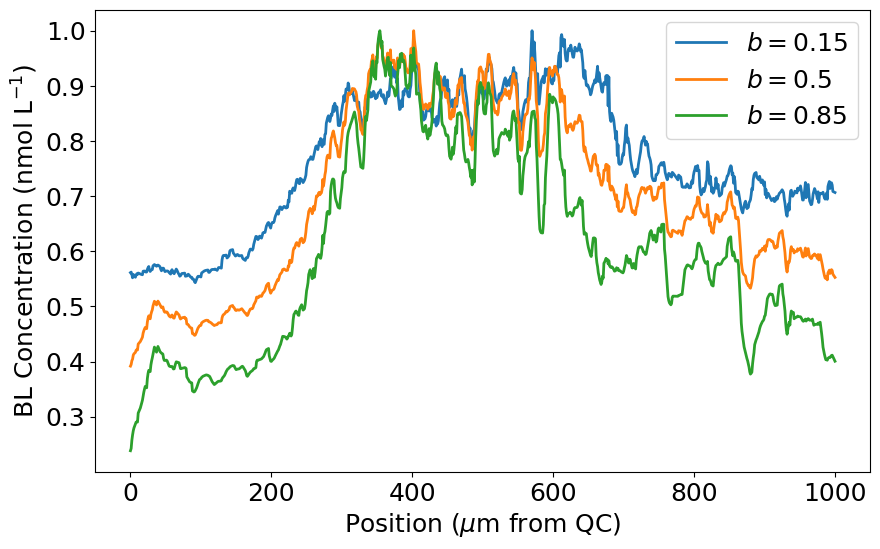

In [4]:
vP = np.linspace(0, 1000, 1001)
for b in [0.15, 0.5, 0.85]:
    BL = get_bl(vP, b, 0)
    plt.plot(BL[:, 0], BL[:, 1], lw = 2, label = fr"$b = {b}$")

plt.xlabel(r"Position ($\mu$m from QC)")
plt.ylabel(r"BL Concentration (nmol L$^{-1}$)")
plt.legend()
plt.savefig(f"{PATH}/bl-bias.png", bbox_inches="tight")

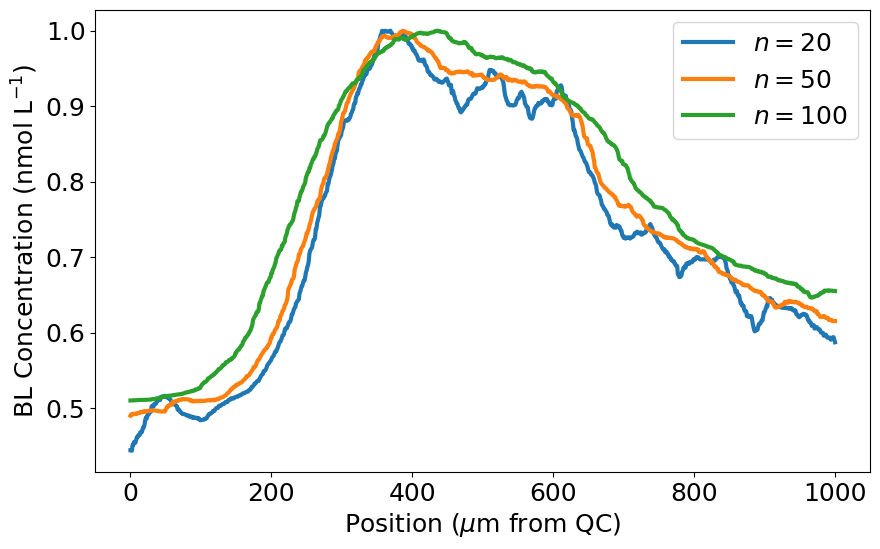

In [5]:
vP = np.linspace(0, 1000, 1001)
for n in [20, 50, 100]:
    BL = get_bl(vP, 0.5, n)
    plt.plot(BL[:, 0], BL[:, 1], lw = 3, label = fr"$n = {n}$")

plt.xlabel(r"Position ($\mu$m from QC)")
plt.ylabel(r"BL Concentration (nmol L$^{-1}$)")
plt.legend()
plt.savefig(f"{PATH}/bl-average.png", bbox_inches="tight")

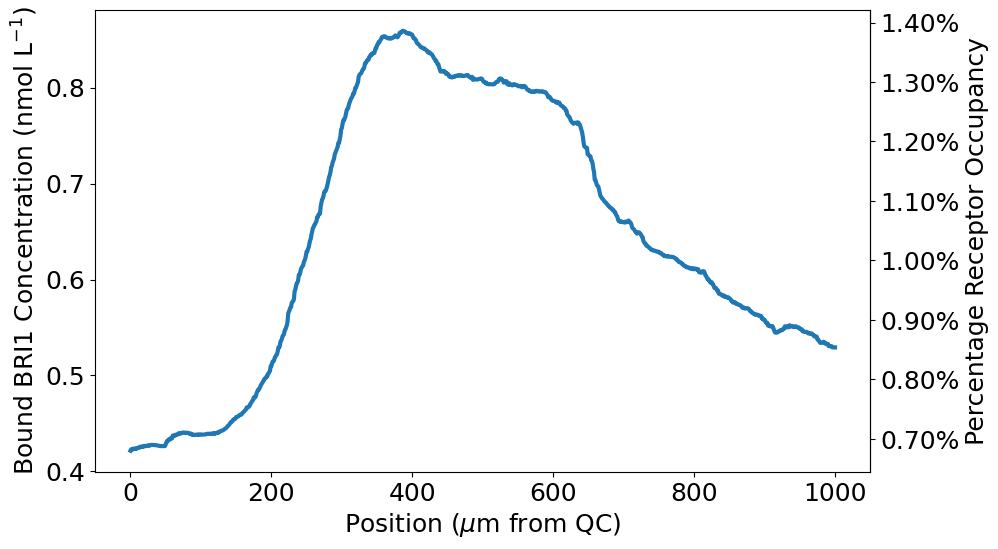

In [6]:
# Get the BL function (b = 0.5, n = 50)
BL = get_bl(vP, 0.5, 50)

# Compute the bound receptors
A = (BL[:, 1] + 62 + 10)
RB = (A - np.sqrt(A ** 2 - 4 * 62 * BL[:, 1])) / 2

# Plot the percentage of bound receptors and the absolute concentration
fig, ax = plt.subplots()
ax.plot(vP, RB, lw = 3)
ax.set_xlabel(r"Position ($\mu$m from QC)")
ax.set_ylabel(r"Bound BRI1 Concentration (nmol L$^{-1}$)")

pct_to_abs = lambda x : x * 62
abs_to_pct = lambda x : 100 * x / 62
secax = ax.secondary_yaxis('right', functions = (abs_to_pct, pct_to_abs))
secax.set_ylabel(r"Percentage Receptor Occupancy")
secax.yaxis.set_major_formatter(mtick.PercentFormatter())

plt.savefig(f"{PATH}/bri1-function.png", bbox_inches="tight")

## Position Function

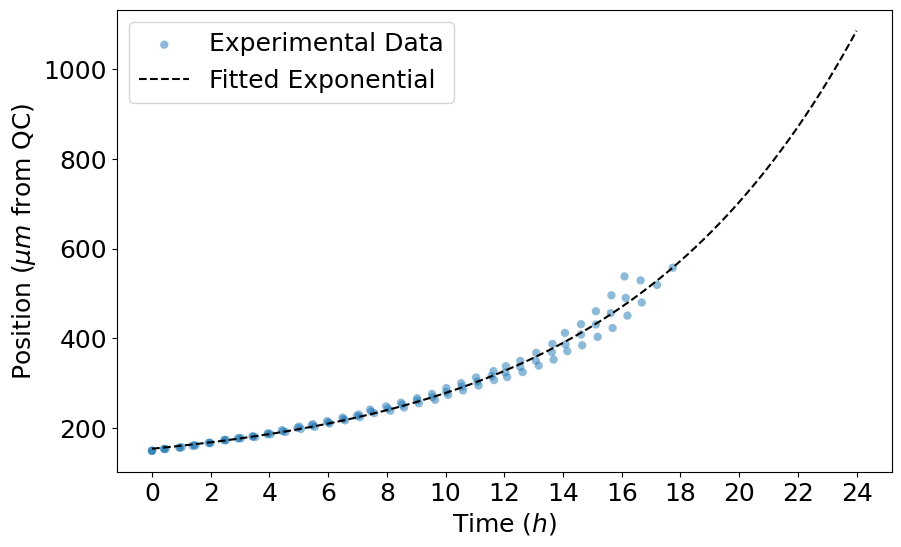

In [7]:
POSITION, time_to_position, position_to_time = get_position()
vT = np.linspace(0, 24, 1000)

plt.xlabel(r"Time ($h$)")
plt.ylabel(r"Position ($\mu m$ from QC)")
plt.xticks(np.arange(0, 26, 2))
plt.scatter(POSITION[:, 0], POSITION[:, 1], alpha = 0.5, edgecolor = "none", label = "Experimental Data")
plt.plot(vT, time_to_position(vT), "k--", label = "Fitted Exponential")
plt.legend()
plt.savefig(f"{PATH}/position-function.png", bbox_inches="tight")

In [8]:
mpl.rcParams['figure.figsize'] = (10, 8)

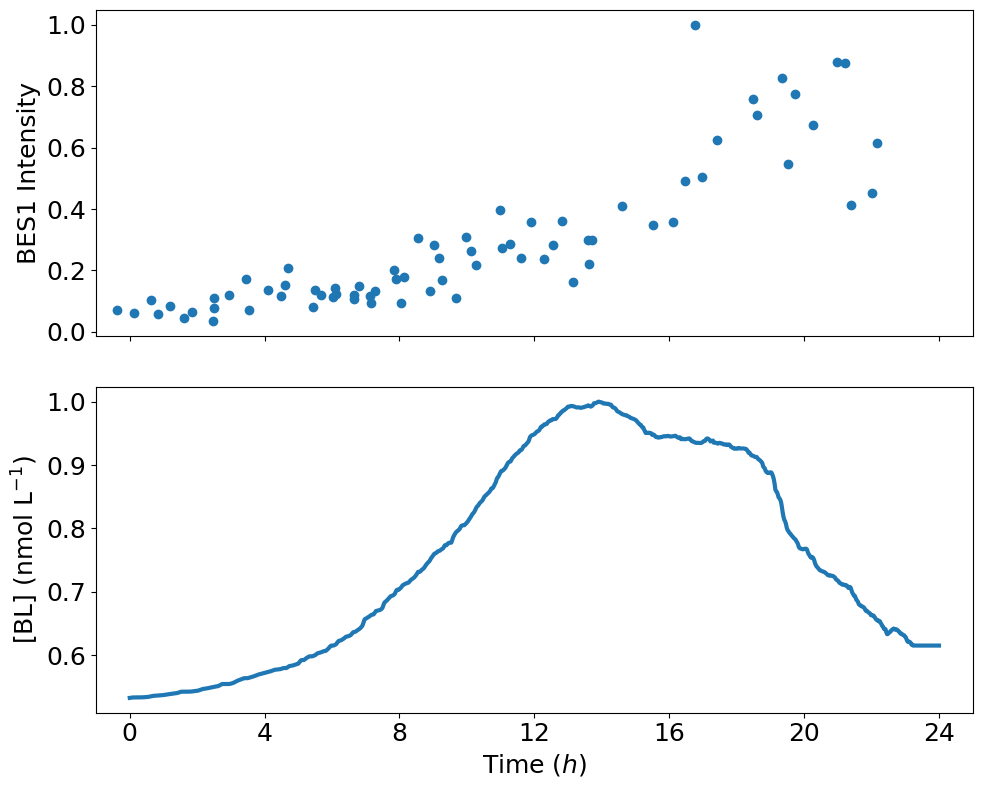

In [10]:
# Get BL function in terms of position then convert to time
BL = get_bl(vP, 0.5, 50)
BL_interp = np.interp(time_to_position(vT), BL[:, 0], BL[:, 1])

# Get BES1 function in terms of position then convert to time
BES1 = get_bes1_data()

# Plot the BES1 data and BL function
fig, (ax1, ax2) = plt.subplots(nrows = 2, sharex = True)
fig.tight_layout()

ax1.set_ylabel(r"BES1 Intensity")
ax1.set_xticks(np.arange(0, 28, 4))
ax1.set_yticks(np.arange(0, 1.2, 0.2))
ax1.set_xlim((-1, 25))
ax1.scatter(position_to_time(BES1[:, 0]), BES1[:, 1])

ax2.set_xlabel(r"Time ($h$)")
ax2.set_ylabel(r"[BL] (nmol L$^{-1}$)")
ax2.set_xticks(np.arange(0, 28, 4))
ax2.plot(vT, BL_interp, lw = 3, label = fr"$n = {n}$")
plt.savefig(f"{PATH}/bes1-data.png", bbox_inches="tight")

## Mutant Data Processing

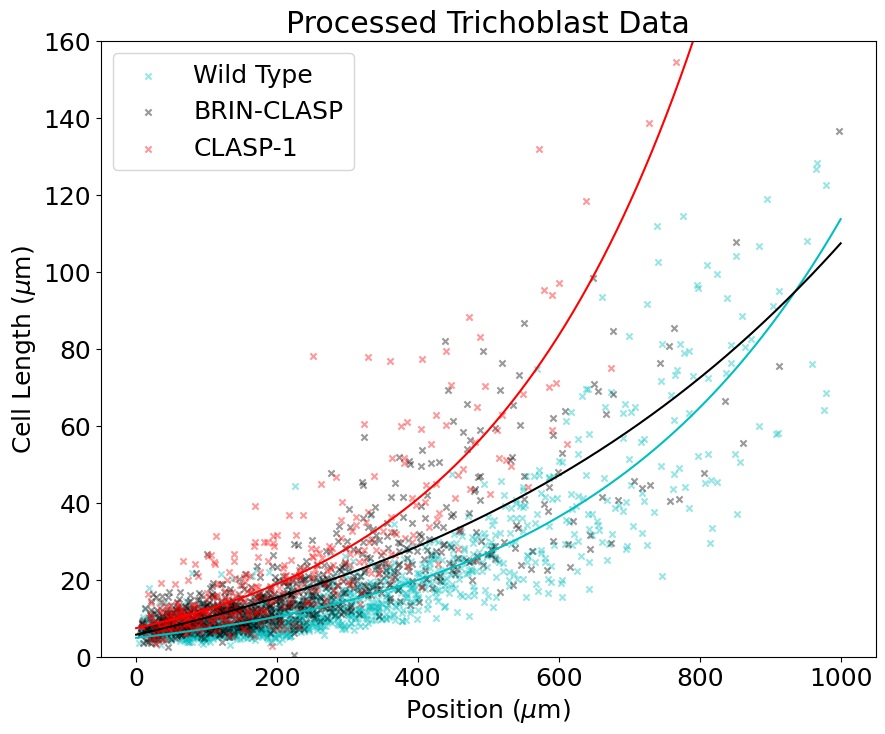

In [19]:
# Create the plot
plt.xlabel(r"Position ($\mu$m)")
plt.ylabel(r"Cell Length ($\mu$m)")
plt.ylim((0, 160))
plt.title(f"Processed Trichoblast Data")

# Plot the Wild Type
wt_data, wt_fit = get_mutant_data("trichoblast", "WT-", 10, 12)
plt.plot(vP, wt_fit(vP / 1000), "c-")
plt.scatter(wt_data[:, 0], wt_data[:, 1], s=20, alpha=0.4, c="c", marker="x", label="Wild Type")

# Plot the BRIN-CLASP
bc_data, bc_fit = get_mutant_data("trichoblast", "BC-", 10, 12)
plt.plot(vP, bc_fit(vP / 1000), "k-")
plt.scatter(bc_data[:, 0], bc_data[:, 1], s=20, alpha=0.4, c="k", marker="x", label="BRIN-CLASP")

# Plot the CLASP-1
c1_data, c1_fit = get_mutant_data("trichoblast", "C1-", 10, 12)
plt.plot(vP, c1_fit(vP / 1000), "r-")
plt.scatter(c1_data[:, 0], c1_data[:, 1], s=20, alpha=0.4, c="r", marker="x", label="CLASP-1")

# Configure the plot  
mpl.rcParams['font.size'] = 18
mpl.rcParams['figure.figsize'] = (10, 8)
plt.legend()
plt.savefig(f"{PATH}/data-trichoblast.png")

BRIN-CLASP T-test: TtestResult(statistic=-19.96469489148977, pvalue=3.044985021904292e-81, df=2070.0)
CLASP-1 T-test: TtestResult(statistic=-27.759961976060367, pvalue=1.3868223534404128e-139, df=1656.0)


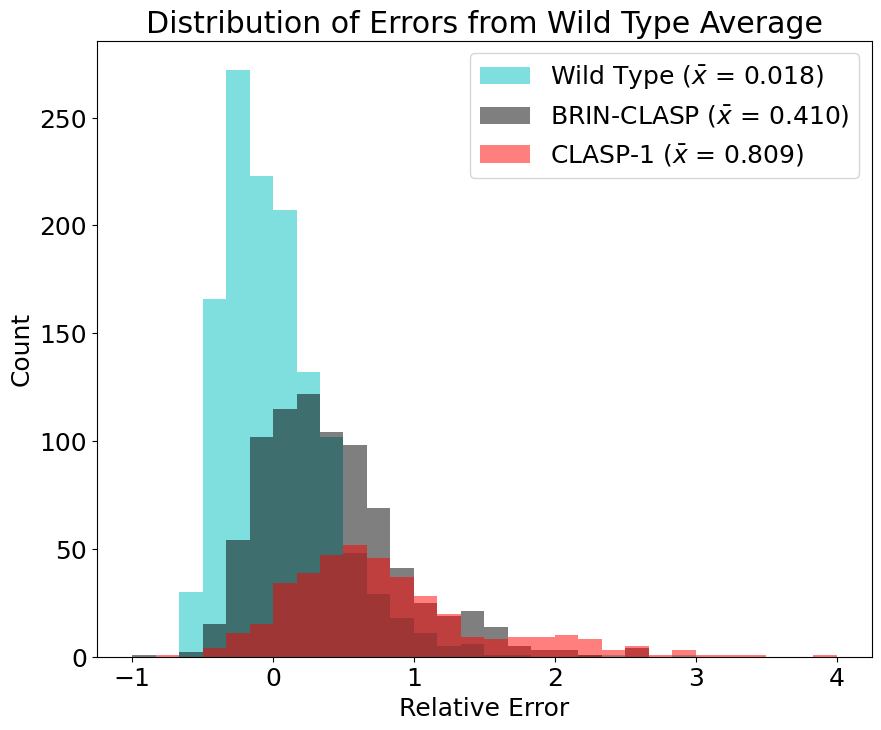

In [12]:
# Quantify the percentage errors from the fitted curve
wt_approx = wt_fit(wt_data[:, 0] / 1000)
bc_approx = wt_fit(bc_data[:, 0] / 1000)
c1_approx = wt_fit(c1_data[:, 0] / 1000)

wt_error = (wt_data[:, 1] - wt_approx) / wt_approx
bc_error = (bc_data[:, 1] - bc_approx) / bc_approx
c1_error = (c1_data[:, 1] - c1_approx) / c1_approx

plt.title("Distribution of Errors from Wild Type Average")
plt.ylabel("Count")
plt.xlabel("Relative Error")

wt_label = f"Wild Type (" + r"$\bar{x}$ = " + f"{np.mean(wt_error):.3f})"
bc_label = f"BRIN-CLASP (" + r"$\bar{x}$ = " + f"{np.mean(bc_error):.3f})"
c1_label = f"CLASP-1 (" + r"$\bar{x}$ = " + f"{np.mean(c1_error):.3f})"
plt.hist(wt_error, bins = 30, range=(-1, 4), color = 'c', alpha = 0.5, label = wt_label)
plt.hist(bc_error, bins = 30, range=(-1, 4), color = 'k', alpha = 0.5, label = bc_label)
plt.hist(c1_error, bins = 30, range=(-1, 4), color = 'r', alpha = 0.5, label = c1_label)
plt.legend()
plt.savefig(f"{PATH}/trichoblast-distribution.png")

# Determine the p-value
print(f"BRIN-CLASP T-test: {ttest_ind(wt_error, bc_error)}")
print(f"CLASP-1 T-test: {ttest_ind(wt_error, c1_error)}")

[8.6528575  0.3019458  0.24757581]
[8.46902085 2.4014762  0.15295823]
[15.73100854  0.84716686  0.23861381]


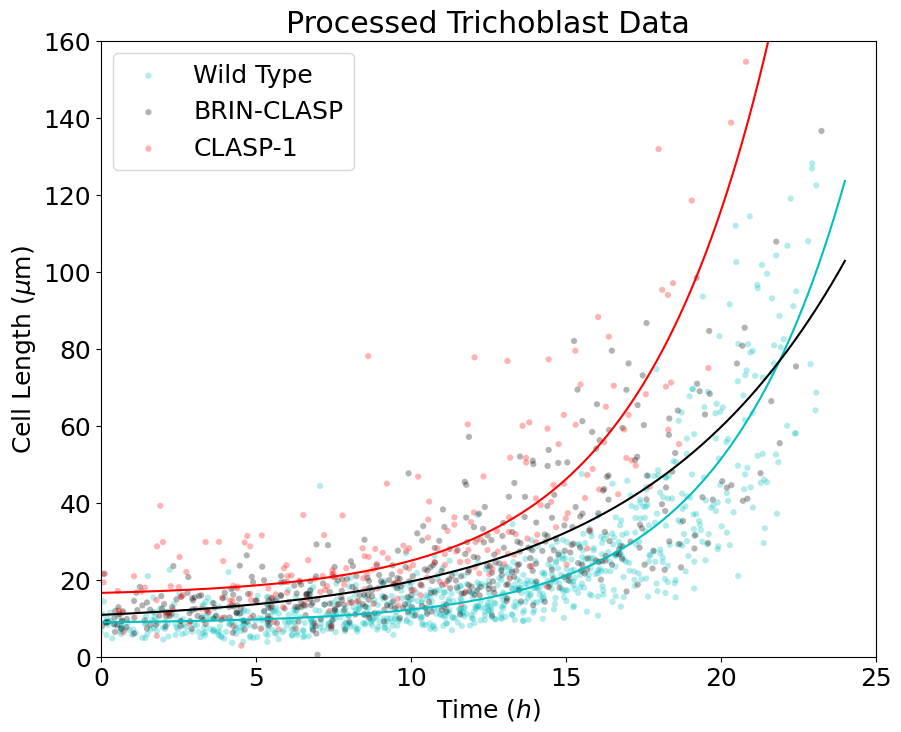

In [14]:
# Create the plot with time rescaled data
plt.xlabel(r"Time ($h$)")
plt.ylabel(r"Cell Length ($\mu$m)")
plt.ylim((0, 160))
plt.xlim((0, 25))
plt.title(f"Processed Trichoblast Data")

# Transform the position data to be between within 150um and 1000um
wt_tdata = wt_data[(wt_data[:, 0] > 150) & (wt_data[:, 0] < 1000)]
bc_tdata = bc_data[(bc_data[:, 0] > 150) & (bc_data[:, 0] < 1000)]
c1_tdata = c1_data[(c1_data[:, 0] > 150) & (c1_data[:, 0] < 1000)]

# Then convert position to time for each mutant
wt_tdata[:, 0] = position_to_time(wt_tdata[:, 0])
bc_tdata[:, 0] = position_to_time(bc_tdata[:, 0])
c1_tdata[:, 0] = position_to_time(c1_tdata[:, 0])

# Get the time fitted functions
f = lambda x, A, B, C : A + B * np.exp(C * x)
wt_tfit, wt_trmse = fit_curve(f, wt_tdata)
bc_tfit, bc_trmse = fit_curve(f, bc_tdata)
c1_tfit, c1_trmse = fit_curve(f, c1_tdata)

# Plot the Wild Type
plt.plot(vT, wt_tfit(vT), "c-")
plt.scatter(wt_tdata[:, 0], wt_tdata[:, 1], s=20, alpha=0.3, c="c", edgecolor = "none", label="Wild Type")

# Plot the BRIN-CLASP
plt.plot(vT, bc_tfit(vT), "k-")
plt.scatter(bc_tdata[:, 0], bc_tdata[:, 1], s=20, alpha=0.3, c="k", edgecolor = "none", label="BRIN-CLASP")

# Plot the CLASP-1
plt.plot(vT, c1_tfit(vT), "r-")
plt.scatter(c1_tdata[:, 0], c1_tdata[:, 1], s=20, alpha=0.3, c="r", edgecolor = "none", label="CLASP-1")

# Configure the plot  
plt.legend()
# plt.savefig(...)